### Downloading Dataset

In [3]:
!mkdir /dataset
!wget -P /dataset/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /dataset/train-test-data.zip -d /dataset

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/test/Elmar_Brok_21.jpg  
  inflating: /dataset/test/Elmar_Brok_30.jpg  
  inflating: /dataset/test/Elmar_Brok_31.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_00.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_01.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_10.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_11.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_40.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_41.jpg  
  inflating: /dataset/test/Elton_John_10.jpg  
  inflating: /dataset/test/Elton_John_11.jpg  
  inflating: /dataset/test/Elton_John_20.jpg  
  inflating: /dataset/test/Elton_John_21.jpg  
  inflating: /dataset/test/Elton_John_30.jpg  
  inflating: /dataset/test/Elton_John_31.jpg  
  inflating: /dataset/test/Elton_John_40.jpg  
  inflating: /dataset/test/Elton_John_41.jpg  
  inflating: /dataset/test/Emile_Lahoud_00.jpg  
  inflating: /dataset/test/Emile_Lahoud_01.jpg  
  inflating: /da

In [4]:
import os
files = os.listdir('/dataset')

In [5]:
files

['test',
 'test_frames_keypoints.csv',
 'training_frames_keypoints.csv',
 'training',
 'train-test-data.zip']

In [6]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [7]:
# Load our key points dataset
key_pts_frame = pd.read_csv('/dataset/training_frames_keypoints.csv')

key_pts_frame.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [8]:
n = 0
image_name = key_pts_frame.iloc[n,0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
print(key_pts.shape)
key_pts = key_pts.astype('float').reshape(-1, 2)
print(key_pts.shape)
print(key_pts[0])

print(f'Image name: {image_name}')
print(f'Landmarks shape: {key_pts.shape}')
print(f'First four keypoints: {key_pts[:4]}')

(136,)
(68, 2)
[45. 98.]
Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First four keypoints: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [9]:
# Number of images
print(f'Number of images: {key_pts_frame.shape[0]}')

Number of images: 3462


In [10]:
# Show images with keypoints
def show_keypoints(image, key_pts):
  plt.imshow(image)
  plt.scatter(key_pts[:, 0], key_pts[:,1], s=20, marker='.', c='m')
  plt.pause(0.001)  # pause a bit so that plots are updated

Shape of image: (360, 389, 4)


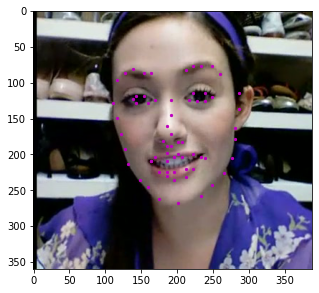

In [11]:
# Display an image with keypoints
n = 75
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
img = mpimg.imread(os.path.join('/dataset/training/', image_name))
print(f'Shape of image: {img.shape}')
show_keypoints(img, key_pts)
plt.show()

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.


In [14]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
  def __init__(self,csv_file, root_dir, transform=None):
    self.key_pts_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.key_pts_frame)
  
  def __getitem__(self, idx):
    image_name = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx,0])
    image = mpimg.imread(image_name)

    # if image has an alpha color channel, get rid of it
    if image.shape[2] == 4:
      image = image[:,:,0:3]
    
    key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
    key_pts = key_pts.astype('float').reshape(-1,2)
    sample = {"image":image, "key_pts":key_pts}

    if self.transform:
      sample = self.transform(sample)

    return sample

In [15]:
# Let's initiate this class and display some images
face_dataset = FacialKeypointsDataset(csv_file='/dataset/training_frames_keypoints.csv', root_dir='/dataset/training')

# print some stats about the dataset
print(f'Length of Dataset: {len(face_dataset)}')

Length of Dataset: 3462


1/3 	 (196, 165, 3) 	 (68, 2)


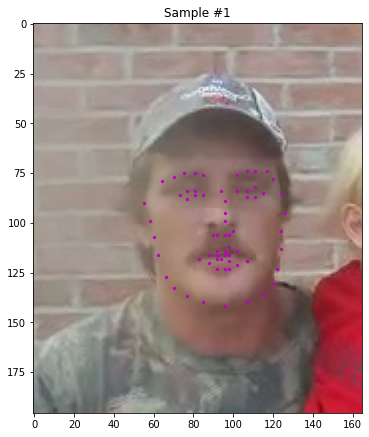

2/3 	 (240, 200, 3) 	 (68, 2)


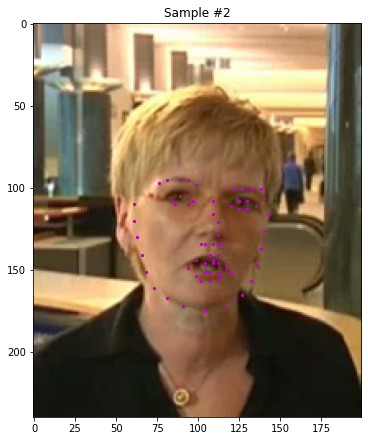

3/3 	 (168, 149, 3) 	 (68, 2)


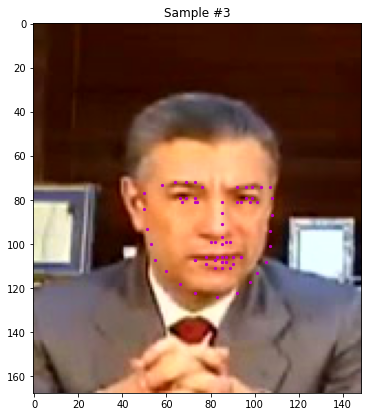

In [17]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
  # define the size of images
  fig = plt.figure(figsize=(20,10))

  # randomly select a sample
  rand_i = np.random.randint(0,len(face_dataset))
  sample = face_dataset[rand_i]

  # print the shape of the image and the keypoints
  print(f'{i+1}/{num_to_display} \t {sample["image"].shape} \t {sample["key_pts"].shape}')

  ax = plt.subplot(1, num_to_display, i+1)
  ax.set_title(f'Sample #{i+1}')

  show_keypoints(image=sample['image'], key_pts=sample['key_pts'])

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)


In [27]:
import torch
from torchvision import transforms, utils

class Normalize(object):
  """ Convert a color image to grayscale and normalize the color range to [0,1] """
  
  def __call__(self,sample):
    image, key_pts = sample['image'], sample['key_pts']

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    # convert image to grayscale
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale range from [0,255] to [0,1]
    image_copy = image_copy / 255.0

    # scale keypoints to be centered around 0 with a range of [-1,1]
    # mean = 100, sqrt = 50, so pts should be (pts-100) / 50

    key_pts_copy = (key_pts_copy - 100) / 50.0

    return {"image":image_copy, "key_pts":key_pts_copy}

class Rescale(object):
  """ Rescale the image in a sample to a given size"""

  def __init__(self, output_size):
    assert isinstance(output_size, (int,tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['key_pts']
    h,w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w , self.output_size
      else:
        new_h, new_w = self.output_size , self.output_size * w / h
    else:
      new_h, new_w = self.output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w,new_h))

    # scale the pts, too
    key_pts = key_pts * [new_w / w, new_h / h]

    return {"image":img, "key_pts":key_pts}

class RandomCrop(object):
  """ Crop Randomly the image in a sample"""

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2
      self.output_size = output_size
    
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['key_pts']
    
    h,w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top+new_h, left:left+new_w]

    key_pts = key_pts - [left, top]
    
    return {"image":image, "key_pts":key_pts}

class ToTensor(object):
  """ Convert ndarrays in samplt to Tensors. """

  def __call__(object, sample):
    image, key_pts = sample['image'], sample['key_pts']

    # if image has no grayscale color channel, add one
    if len(image.shape) == 2:
      # add the third color dim
      image = image.reshape(image.shape[0], image.shape[1], 1)
    
    # swap color axis, because
    # Numpy image: H x W x C
    # Tensor image: C x H x W
    image = image.transpose((2,0,1))

    return {'image': torch.from_numpy(image), 'key_pts': torch.from_numpy(key_pts)}

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. As you look at each transform, note that, in this case, **order does matter**. For example, you cannot crop a image using a value smaller than the original image (and the orginal images vary in size!), but, if you first rescale the original image, you can then crop it to any size smaller than the rescaled size.

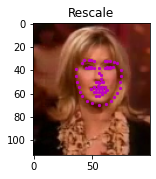

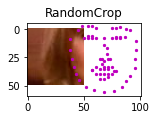

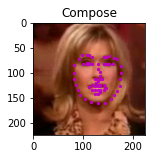

In [28]:
rescale = Rescale(100)
crop = RandomCrop(50)

composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transform to the sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
  transformed_sample = tx(sample)

  ax = plt.subplot(1,3,i+1)
  plt.tight_layout()
  ax.set_title(type(tx).__name__)
  show_keypoints(transformed_sample['image'], transformed_sample['key_pts'])

plt.show()

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

In [29]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/dataset/training_frames_keypoints.csv',
                                             root_dir='/dataset/training', 
                                             transform = data_transform)

In [31]:
print(f'Number of images: {len(transformed_dataset)}')

for i in range(5):
  sample = transformed_dataset[i]
  print(f'{i} \t {sample["image"].size()} \t {sample["key_pts"].size()}')

Number of images: 3462
0 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
1 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
2 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
3 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
4 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])


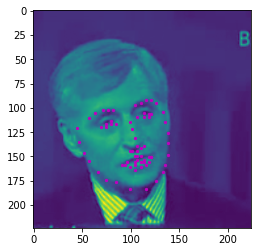

In [41]:
# Visualizing one sample from transformed_dataset
idx = 899
sample = transformed_dataset[idx]
image, key_pts = sample["image"], sample["key_pts"]
key_pts = (key_pts * 50) + 100  # Denormalizing keypoints
show_keypoints(np.squeeze(image), key_pts)